# Logistic Regression (No rolling window)

Accuracy: 0.7638
F1 Score: 0.7780
AUC-ROC: 0.8280

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            5279          2051
Actual Up              1514          6246


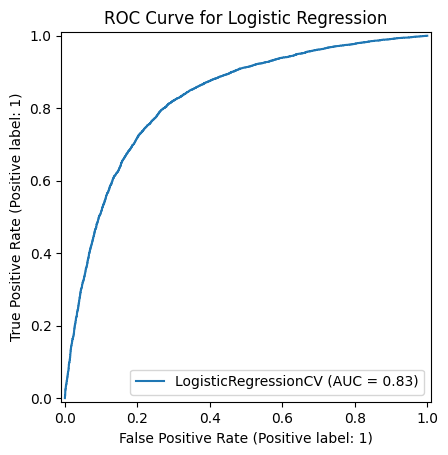

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['ticker', 'Date'])

# Create target variable (1 if current close > previous close)
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target'] = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close'])

# Feature engineering
features = ['Open', 'High', 'Low', 'Volume']
X = df[features]
y = df['target']

# Time-aware split preserving ticker groups
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=df['ticker']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training with built-in cross-validation
model = LogisticRegressionCV(
    Cs=10,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

# Predictions and probabilities
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']))

# ROC Curve visualization
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('ROC Curve for Logistic Regression')
plt.show()

# Logistic Regression (Rolling Window - 10 days; Model retrained yearly)

/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_62706/2879771869.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Year'] = test_df['Date'].dt.year


Rolling Window Results:
Accuracy: 0.7666
F1 Score: 0.7794
AUC-ROC: 0.8263

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            5345          1949
Actual Up              1573          6223


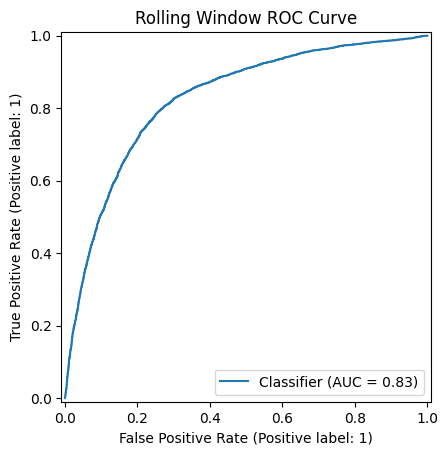

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date', 'ticker']).reset_index(drop=True)

# Create target variable (1 if current close > previous close)
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target'] = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close']).reset_index(drop=True)

features = ['Open', 'High', 'Low', 'Volume']

# Split into train and test, maintaining temporal consistency
n_total = len(df)
train_size = int(0.8 * n_total)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Add year column for grouping
test_df['Year'] = test_df['Date'].dt.year
unique_years = sorted(test_df['Year'].unique())

all_y_true = []
all_y_pred = []
all_y_proba = []
all_test_dates = []

for idx, year in enumerate(unique_years):
    # For each year in test set:
    year_mask = test_df['Year'] == year
    year_test = test_df[year_mask].reset_index(drop=True)
    if idx == 0:
        # For the first year, use the initial 80% train set
        year_train = train_df.copy()
    else:
        # For subsequent years, use 80% of all data up to the start of this year
        cutoff_date = year_test['Date'].min()
        up_to_year = df[df['Date'] < cutoff_date]
        year_train_size = int(0.8 * len(up_to_year))
        year_train = up_to_year.iloc[:year_train_size]

    # Prepare train data
    X_train = year_train[features]
    y_train = year_train['target']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train model ONCE for the year
    model = LogisticRegressionCV(Cs=10, cv=5, scoring='roc_auc', random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Rolling window prediction for this year
    test_size = 10
    n_test = len(year_test)
    start = 0
    while start + test_size <= n_test:
        test_batch = year_test.iloc[start:start+test_size]
        X_test_batch = test_batch[features]
        y_test_batch = test_batch['target']

        # Use scaler fitted on train
        X_test_batch_scaled = scaler.transform(X_test_batch)

        # Predict
        y_pred_batch = model.predict(X_test_batch_scaled)
        y_proba_batch = model.predict_proba(X_test_batch_scaled)[:, 1]

        # Store results
        all_y_true.extend(y_test_batch)
        all_y_pred.extend(y_pred_batch)
        all_y_proba.extend(y_proba_batch)
        all_test_dates.extend(test_batch['Date'])

        start += test_size

# Evaluation
accuracy = accuracy_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred)
auc = roc_auc_score(all_y_true, all_y_proba)
cm = confusion_matrix(all_y_true, all_y_pred)

print(f"Rolling Window Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']))

# ROC Curve
RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling Window ROC Curve')
plt.show()
